### This is a document showing the process we used for finding the temperature dependent changes in electron transmission for carbon nano ribbons

In [50]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import os

# For handling structures and visualizing structures
from ase import Atoms
from ase.build import graphene_nanoribbon
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io import read, write

# For MD
from ase.calculators.tersoff import Tersoff
from ase.constraints import FixAtoms
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ase.neighborlist import neighbor_list

# import functions
from presentation_functions import *

Number of atoms (and orbitals) in unit cell: 20


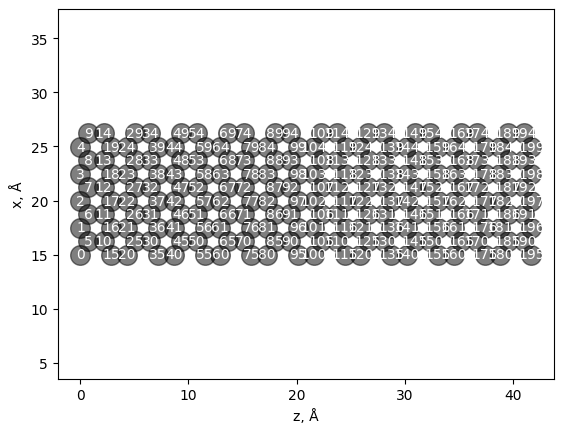

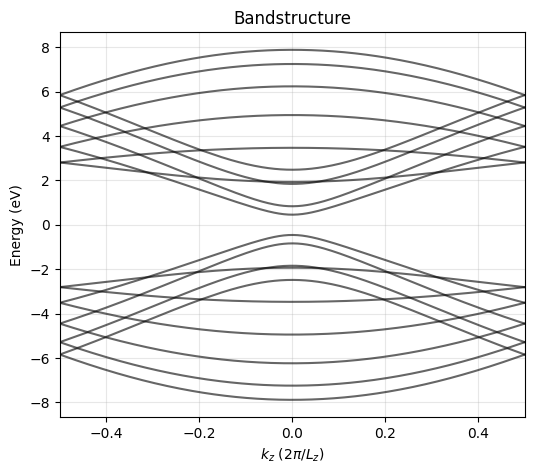

In [51]:
# Creating structure
kind = "armchair"     # "armchair" or "zigzag"
n = 5                 # width of ribbon
length = 1            # length of unit cell
vacuum = 15.0         # vacuum in non-periodic directions (Å)
bond = 1.43877067     # Optimized for C.tersoff potential 
Vpppi = -2.7          

ribbon = graphene_nanoribbon(n=n, m=length, type=kind, C_C=bond, vacuum=vacuum)
ribbon.pbc = True
ribbon = sort_atoms(ribbon)

Ntransport = 10 # number of repetitions in transport direction
pristine_structure = ribbon.repeat((1, 1, Ntransport))

nL = len(ribbon)
nR = nL
print("Number of atoms (and orbitals) in unit cell:", nL)

draw_atoms(pristine_structure)
plot_bandstructure(ribbon)

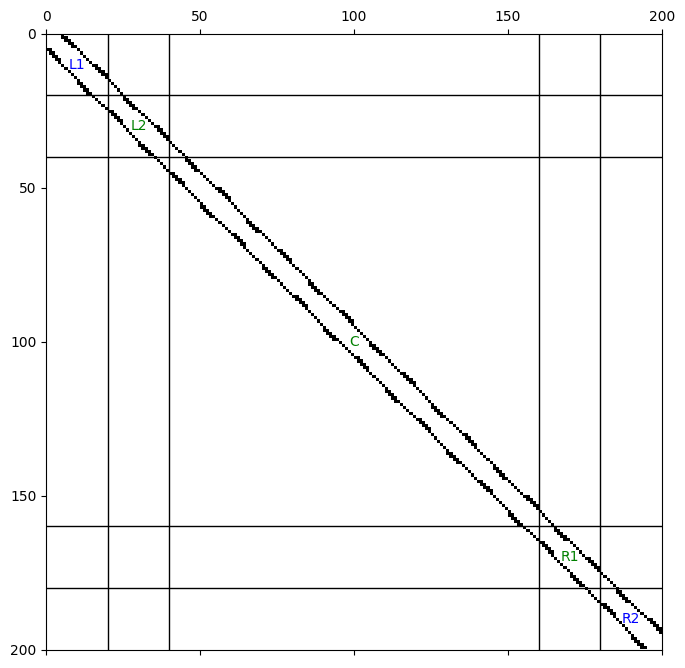

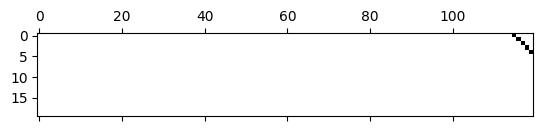

In [52]:
positions = pristine_structure.get_positions()
Hbig = hamdd(positions)

plot_ham(nL, nR, Hbig)

HL, VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD = SplitHam(Hbig, nL, nR)
plt.spy(VRC)

### Calculating transmission

In [53]:
dim = HC.shape[0]
I = np.eye(dim, dtype=complex)

energy = np.linspace(-10,10,200)
transmission = np.zeros_like(energy)
for i, e in enumerate(energy):
    z = e + 1j*1e-8
    gl_s, gl_b, sigmal_s, sigmal_b = get_surface_greens_function(HL, VL, z)
    gr_s, gr_b, sigmar_s, sigmar_b = get_surface_greens_function(HR, VR, z)

    # left and right lead, eq 134
    sigma_L = VLC.T.conj() @ gl_s @ VLC
    sigma_R = VRC.T.conj() @ gr_s @ VRC

    # gammas, eq 136
    gamma_L = 1j * (sigma_L - sigma_L.T.conj())
    gamma_R = 1j * (sigma_R - sigma_R.T.conj())

    g_C = np.linalg.inv(z * I - HC - sigma_L - sigma_R)
    t_matrix = gamma_R @ g_C @ gamma_L @ g_C.T.conj()

    transmission[i] = np.trace(t_matrix).real

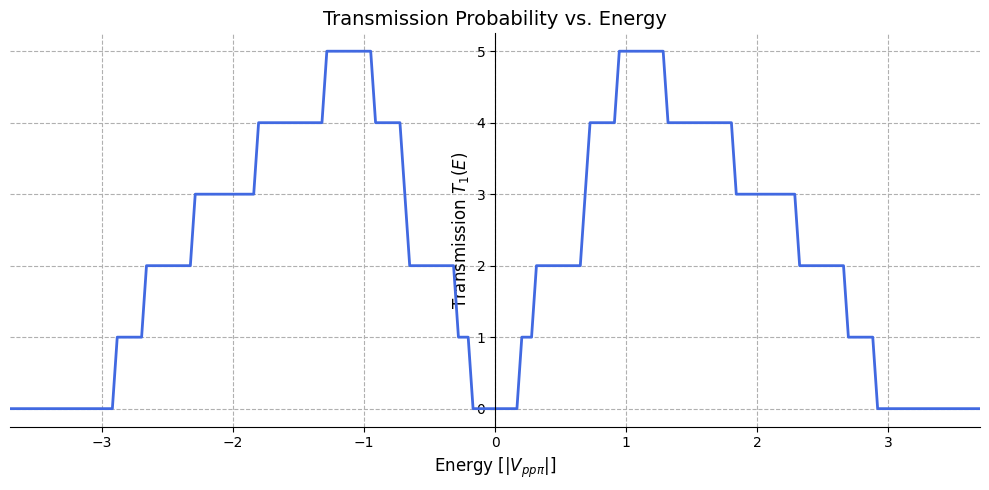

In [54]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

# Plot 1: Transmission 1
ax1.plot(energy / 2.7, transmission, color='royalblue', linewidth=2)
ax1.set_ylabel(r'Transmission $T_1(E)$', fontsize=12)
ax1.set_xlabel(r'Energy $[|V_{pp\pi}|]$', fontsize=12)
ax1.set_title('Transmission Probability vs. Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=1)

# y-axis spine at x = 0
ax1.spines['left'].set_position(('data', 0))
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

plt.xlim(energy.min()/-Vpppi, energy.max()/-Vpppi) # V_pppi units
plt.tight_layout()
plt.show()

In [55]:
md_structure = pristine_structure.copy()

# Load parameter file
calc = Tersoff.from_lammps("C.tersoff")

# Set up calculator
md_structure.calc = calc # Attach Tersoff calculator based on parameters in C.tersoff

# Now based on this interatomic potential, we can get total energies and forces:
energy = md_structure.get_potential_energy()
forces = md_structure.get_forces()
print(energy, "eV")
print(forces, "eV/Å")

-1533.7831020173671 eV
[[ 2.94629247e+00  0.00000000e+00 -5.10372143e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.36335387e-13]
 [ 0.00000000e+00  0.00000000e+00 -1.36335387e-13]
 [ 0.00000000e+00  0.00000000e+00 -1.36335387e-13]
 [ 2.94680618e+00  0.00000000e+00 -2.63708103e+00]
 [-2.94680618e+00  0.00000000e+00  2.63708103e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.64242207e-14]
 [ 0.00000000e+00  0.00000000e+00 -2.64242207e-14]
 [ 0.00000000e+00  0.00000000e+00 -2.64242207e-14]
 [-2.94629247e+00  0.00000000e+00  5.10372143e+00]
 [-2.94680618e+00  0.00000000e+00 -2.63708103e+00]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [-2.94629247e+00  0.00000000e+00 -5.10372143e+00]
 [ 2.94629247e+00  0.00000000e+00  5.10372143e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.10474149e-15]
 [ 0.00000000e+00  0.00000000e+00 -9.10474149e-15]
 [ 0.00000000e+00  0.00000000e+00 -9.10474149e-15]
 [ 2.946

<Axes: xlabel='z, Å', ylabel='x, Å'>

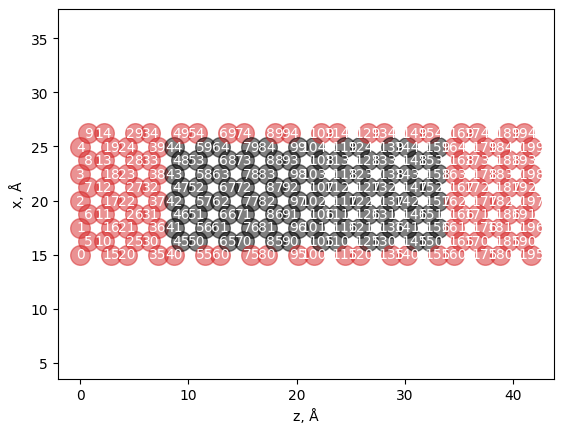

In [56]:
# Fix electrode
natoms = len(md_structure)
fixed_uc = 2 # The number of electrode unit cells to fix on each side.
leftinds = list(range(0,nL*fixed_uc)) # Fix the two first unit cells
rightinds = list(range(natoms-nR*fixed_uc,natoms)) # Fix the two last unit cells

# Fix edges
cutoff = bond + 0.3 # Only nearest neighbor
n_bulk_neighbors = 3 
i, j = neighbor_list("ij", md_structure, cutoff)
counts = np.bincount(i, minlength=len(md_structure))
edgeinds = list(np.where(counts < n_bulk_neighbors)[0])

allinds = np.unique(leftinds+rightinds+edgeinds)
fixed = FixAtoms(mask=allinds)
md_structure.set_constraint(fixed) # Fix L and R electrode
draw_atoms(md_structure) # Red atoms are fixed, grey atoms are free to move

In [ ]:
md_structure.calc = calc

temp_K = 300.0
timestep = 2.0  # Length of timestep in fs
friction = 0.01 # Friction or collision rate in 1/fs
dump = 10        # Choose how often atomic structure is saved along MD trajectory
nsteps = 1000   # Number of steps

filename = 'test_file'

MaxwellBoltzmannDistribution(md_structure, temperature_K=temp_K) # Set random initial velocities

# Clear log file content instead of removing it (to avoid permission errors if open in kernel)
if os.path.exists(f'{filename}.log'):
    try:
        with open(f'{filename}.log', 'w') as f:
            pass
    except PermissionError:
        print(f"Warning: Could not clear {filename}.log. The file is in use.")

if os.path.exists(f'{filename}.xyz'):
    try:
        os.remove(f'{filename}.xyz')
    except PermissionError:
         with open(f'{filename}.xyz', 'w') as f: pass

dyn = Langevin(md_structure, timestep*units.fs, temperature_K=temp_K, friction=friction/units.fs, logfile=f'{filename}.log') # Will append to "md.log" so you might have to delete files inbetween
dyn.attach(lambda: write(f'{filename}.xyz', md_structure, append=True), interval=dump) # Will append to "md.xyz"...

dyn.run(nsteps)

In [60]:
plot_mdlog('test_file.log')

ValueError: could not convert string 'Time[ps]' to float64 at row 519, column 1.